### Exercise 1: Classification with US Airline Sentiment Tweets

##### Import the libraries necessary for this project.

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#### 1. Data Preprocessing & Exploratory Data Analysis (EDA)

##### Load the Tweets dataset and print 5 first rows to get an overview.

In [2]:
tweets_df = pd.read_csv("datasets/Tweets.csv", encoding="utf-8")
tweets_df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


##### Check the quality of some texts by printing 5 random rows.

In [3]:
tweets_df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
9276,570012047917907969,negative,1.0,Late Flight,1.0000,US Airways,NaN,urimiscott,NaN,0,"@USAirways Yes, ground crew finally showed up ...",NaN,2015-02-23 16:07:17 -0800,Rhode Island,Eastern Time (US & Canada)
9170,570084406204997632,negative,1.0,Customer Service Issue,1.0000,US Airways,NaN,worldwideweg,NaN,0,@USAirways No one picks up the phone all day...,NaN,2015-02-23 20:54:48 -0800,NaN,NaN
11771,567768417038761987,neutral,1.0,NaN,NaN,US Airways,NaN,JenniesMagic,NaN,0,@USAirways done,NaN,2015-02-17 11:31:53 -0800,NaN,Eastern Time (US & Canada)
5304,569207022597509120,negative,1.0,Cancelled Flight,0.6885,Southwest,NaN,Jason_Penix,NaN,0,@SouthwestAir I'm upset because we were lied t...,NaN,2015-02-21 10:48:24 -0800,Indiana...Our Indiana,Eastern Time (US & Canada)
5443,569017002439761920,neutral,1.0,NaN,NaN,Southwest,NaN,JohnDePetroshow,NaN,0,@SouthwestAir at troubadour with @Imaginedrago...,NaN,2015-02-20 22:13:19 -0800,"Rhode Island ,Mass,CT",Eastern Time (US & Canada)


##### Checks the sum of NaN values.

In [4]:
tweets_df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

##### Create remove_unwanted function to remove mentions (@user), hashtags (#hashtag), URLs and emojis with regex patterns. We handle them because we want to keep the important context.

In [5]:
def remove_unwanted(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    emojis = re.compile(
        "[\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]", flags=re.UNICODE
    )
    text = emojis.sub(r'', text)
    return text

##### Call remove_unwanted, lowercase text, lemmatize, remove stopwords and return preprocessed texts. Punctuation can influence the meaning of sentences so we keep them for sentiment analysis.

In [6]:
def preprocessing(sentence):
    sentence = remove_unwanted(sentence)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence, language='english', preserve_line=True)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = " ".join(filtered_tokens)
    return filtered_tokens

tokens = [preprocessing(sentence) for sentence in tweets_df['text']]
tweets_df['text'] = [" ".join(token) for token in tokens]
tweets_df['text']

0                                                   said .
1         plus 've added commercial experience ... tacky .
2         n't today ... must mean need take another trip !
3        's really aggressive blast obnoxious `` entert...
4                                  's really big bad thing
                               ...                        
14635                 thank got different flight chicago .
14636    leaving 20 minute late flight. warning communi...
14637                        please bring american airline
14638    money , change flight , n't answer phone ! sug...
14639    8 ppl need 2 know many seat next flight. plz p...
Name: text, Length: 14640, dtype: object

##### Compute sentence lengths and plot the distribution of sentence lengths.

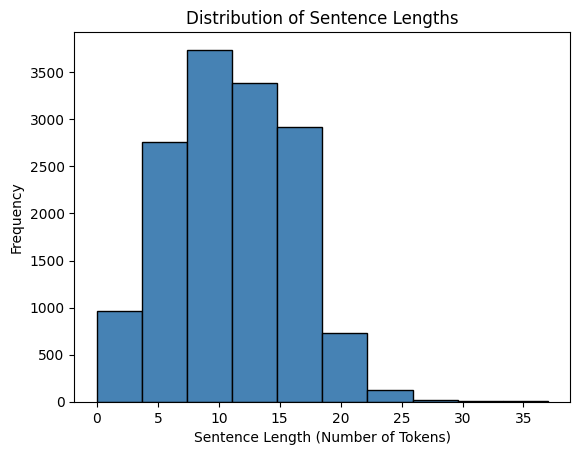

In [7]:
sentence_lengths = []
for token in tokens:
    sentence_lengths.append(len(token))

plt.hist(sentence_lengths, color='steelblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (Number of Tokens)')
plt.ylabel('Frequency')
plt.show()

##### Plot top 10 most frequent words and characters with a bar plot.

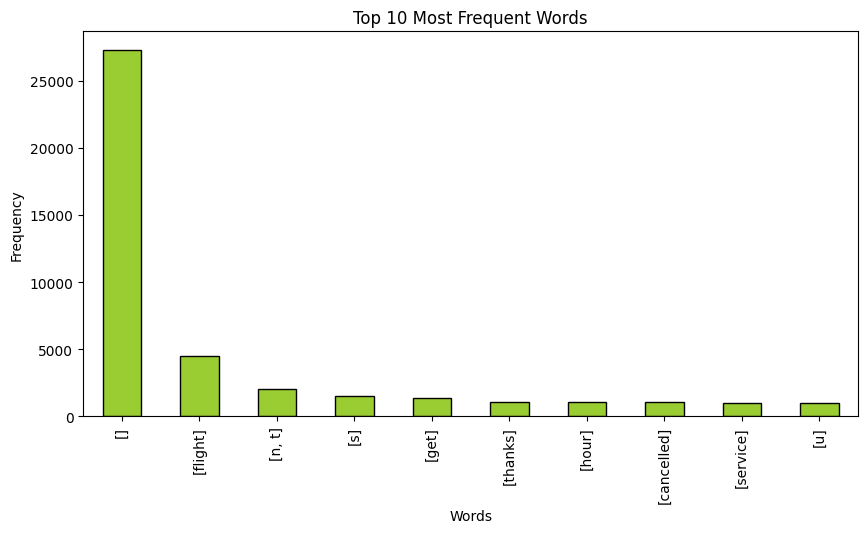

In [27]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
word_freq = pd.Series([tokenizer.tokenize(word) for words in tokens for word in words]).value_counts()
word_freq.head(10).plot(kind='bar', figsize=(10, 5), color='yellowgreen', edgecolor='black')
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

##### Perform advanced EDA by creating word cloud to explore word frequency.

(-0.5, 799.5, 399.5, -0.5)

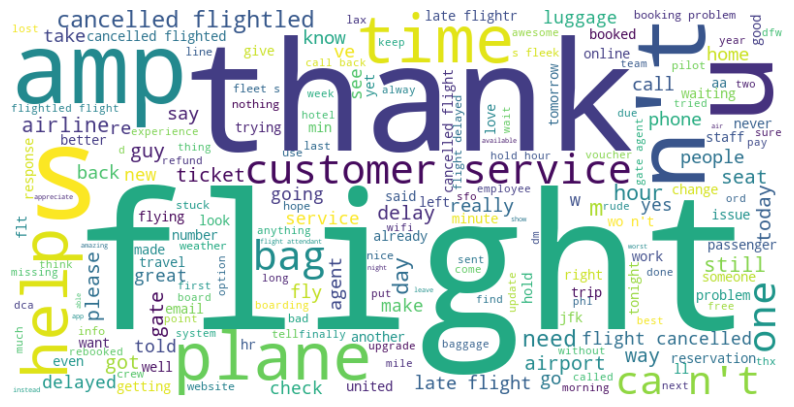

In [9]:
k= (' '.join(tweets_df['text']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(k)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

##### Create a corpus from the filtered data, select the number of topics and train the LDA model.

In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets_df['text'])
corpus = Sparse2Corpus(X, documents_columns=False)
id2word = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}
num_topics = 3
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=10)
for topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(topic)

(0, '0.013*"help" + 0.013*"please" + 0.011*"need" + 0.011*"get" + 0.010*"thank" + 0.009*"number" + 0.008*"ticket" + 0.008*"seat" + 0.008*"email" + 0.007*"phone"')
(1, '0.025*"service" + 0.023*"customer" + 0.018*"thanks" + 0.011*"airline" + 0.010*"like" + 0.007*"never" + 0.007*"would" + 0.007*"great" + 0.007*"ever" + 0.006*"bag"')
(2, '0.072*"flight" + 0.021*"cancelled" + 0.019*"get" + 0.018*"hour" + 0.012*"hold" + 0.011*"time" + 0.010*"flightled" + 0.010*"call" + 0.009*"help" + 0.008*"ca"')


#### 2. Feature Extraction (Vectorization)

##### Encode sentiment labels and set X as texts and numeric labels as y.

In [11]:
label_encoder = LabelEncoder()
tweets_df['label'] = label_encoder.fit_transform(tweets_df['airline_sentiment'])

X = tweets_df['text'].values
y = tweets_df['label'].values

##### Initialize TF-IDF Vectorizer, fit and transform the tweet texts to a dataframe and specify the column names.

In [12]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()
X_tfidf = np.array(X_tfidf, dtype=np.float32)

#### 3. Build the ANN Classifier

##### Split the data into 80% training and 20% testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

##### The following code snippet provided in the course references (Explanation in Kaggle: Deep Tutorial 1 ANN and Classification).

In [14]:
model = Sequential()

# Adding the input layer and specify the input shape here
model.add(Input(shape=(X_tfidf.shape[1],)))

# Adding the first hidden layer
model.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

# Adding the second hidden layer
model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

score, acc = model.evaluate(X_train, y_train, batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

# Part 3 - Making predictions and evaluating the model
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = model.evaluate(X_test, y_test, batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5420 - loss: -52635.8906
Train score: -49028.79296875
Train accuracy: 0.5433743000030518
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
********************
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5374 - loss: -46210.4727  
Test score: -45494.5078125
Test accuracy: 0.5426912307739258


##### Ιn the above code snippet, improve ANN by adding dropout layer. The fraction of input units is 0.1 and used to reduce overfitting. Adding early stopping monitors validation loss and stops training when once the metric has stopped improving.

In [15]:
model = Sequential()

# Adding the input layer and specify the input shape here
model.add(Input(shape=(X_tfidf.shape[1],)))

# Adding the first hidden layer
model.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(rate = 0.1))

# Adding the second hidden layer
model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(rate = 0.1))

# Adding the output layer
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Stop training - epochs to wait before stop training if there is no further improvement 
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0, validation_data=(X_test, y_test), callbacks=[early_stopping])

score, acc = model.evaluate(X_train, y_train, batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

# Part 3 - Making predictions and evaluating the model
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred_classes = np.argmax(y_pred,axis=1)

print('*'*20)
score, acc = model.evaluate(X_test, y_test, batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5966 - loss: -77705.8281
Train score: -73166.3828125
Train accuracy: 0.5963114500045776
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
********************
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6019 - loss: -68886.3906  
Test score: -68075.1015625
Test accuracy: 0.6058743000030518


#### 4. Performance Metrics

In [16]:
accuracy = accuracy_score(y_test, y_pred_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred_classes, average='micro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred_classes, average='micro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred_classes, average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.645150
Precision: 0.645150
Recall: 0.645150
F1 score: 0.645150


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1889
           1       0.28      0.53      0.36       580
           2       0.00      0.00      0.00       459

    accuracy                           0.61      2928
   macro avg       0.36      0.44      0.38      2928
weighted avg       0.57      0.61      0.58      2928



C:\Users\amagklara\PycharmProjects\WordEmbeddings\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amagklara\PycharmProjects\WordEmbeddings\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amagklara\PycharmProjects\WordEmbeddings\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

#### 5. Visualization

##### Plot the training and validation loss curves to visualize the model's performance during training

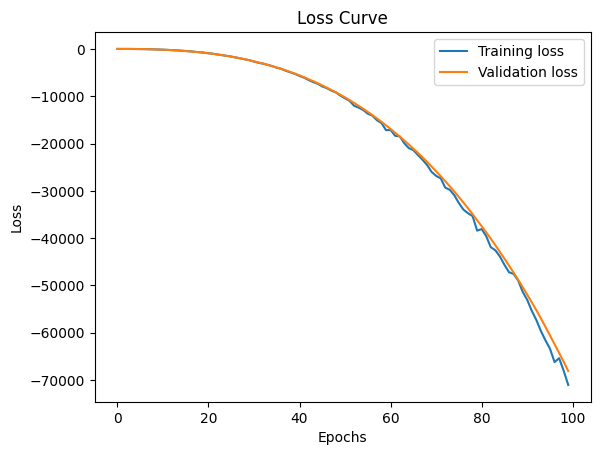

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Plot the confusion matrix with the help of the seaborn heatmap.

Text(0.5, 23.52222222222222, 'Predicted label')

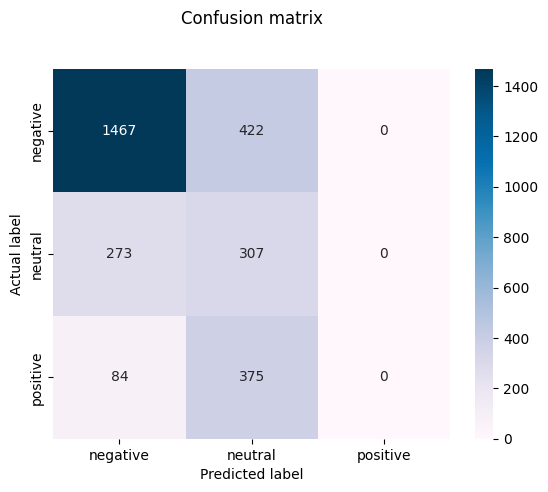

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuBu" ,fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')